# Blindness Detection 

## Multiclass Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup

In [42]:
import re
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

In [ ]:
img_dir = "/content/drive/My Drive/kaggle/blindness detection/train images/"

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
SEED = 42

## 2. Load Data

In [ ]:
df = pd.read_csv("/content/drive/My Drive/kaggle/blindness detection/train/train.csv")

df.sample(5)

,id_code,diagnosis
1116,4eabad7948cf,0
239,1177d583c807,2
1391,6194e0fff071,4
2629,b6a0e348a01e,1
3016,d1b279cc02ae,0


In [ ]:
# split dataset into train, val and test set

train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.2, random_state=SEED)

In [ ]:
# train set
# construct a dataset with image paths and labels

imagePaths = train_df.apply(lambda x : img_dir + str(x[0]) + ".jpg", axis=1).values

labels = train_df.iloc[:, -1].values

train_ds = tf.data.Dataset.from_tensor_slices((imagePaths, labels))

In [ ]:
# validation set

imagePaths = val_df.apply(lambda x : img_dir + str(x[0]) + ".jpg", axis=1).values

labels = val_df.iloc[:, -1].values

val_ds = tf.data.Dataset.from_tensor_slices((imagePaths, labels))

In [ ]:
# list of image paths from train dataset

for f in train_ds.take(5):
    print(f[0].numpy())

b'/content/drive/My Drive/kaggle/blindness detection/train images/b2b79b37d314.jpg'
b'/content/drive/My Drive/kaggle/blindness detection/train images/175dd560810a.jpg'
b'/content/drive/My Drive/kaggle/blindness detection/train images/c3cd0200df79.jpg'
b'/content/drive/My Drive/kaggle/blindness detection/train images/cfed7c1172ec.jpg'
b'/content/drive/My Drive/kaggle/blindness detection/train images/e811f39a1243.jpg'


In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
print("Training images count: ", str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
print("Validating images count: ", str(VAL_IMG_COUNT))

Training images count:  2929
Validating images count:  733


In [ ]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.

def get_label(label):
    return tf.one_hot(label, 5)

def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.image.resize(image, IMAGE_SIZE)

def preprocess(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    label = get_label(label)
    return image, label

In [ ]:
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [1. 0. 0. 0. 0.]


In [ ]:
def augment(image):
    
    # image ops
    image = tf.image.random_contrast(image, 0.75, 1.25)
    image = tf.image.random_saturation(image, 0.75, 1.25)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=2)

    return image

In [ ]:
def prepare_for_training(ds, augmentation=False):
    
    # ds = ds.cache()
    
    if augmentation:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size=BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds, augmentation=True)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

## 3. Visualize the dataset

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30, 30))
    for n in range(5):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


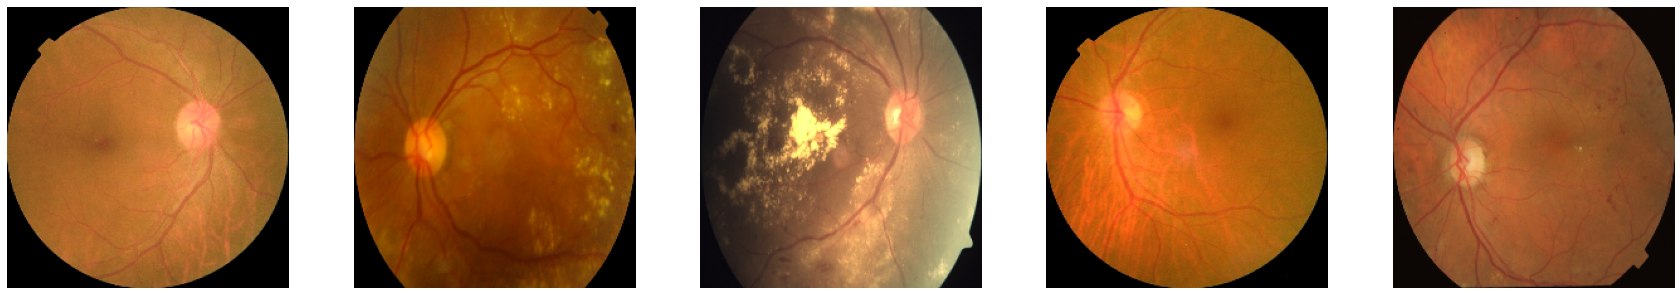

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. Build the CNN

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/kaggle/blindness detection/models/model_at_{epoch}.h5", 
                                                   save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)

lr_plateau_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=6)

In [ ]:
callbacks = [checkpoint_cb, early_stopping_cb, lr_plateau_cb]

## 5. Measure to cope with data imbalance

In [ ]:
no_dr, mild, moderate, severe, dr = np.bincount(df['diagnosis'])
total = no_dr + mild + moderate + severe + dr

weight_for_0 = (1 / no_dr) * (total) / 2.0 
weight_for_1 = (1 / mild) * (total) / 2.0
weight_for_2 = (1 / moderate) * (total) / 2.0 
weight_for_3 = (1 / severe) * (total) / 2.0
weight_for_4 = (1 / dr) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))

Weight for class 0: 1.01
Weight for class 1: 4.95
Weight for class 2: 1.83
Weight for class 3: 9.49
Weight for class 4: 6.21


## 6. Train the model

In [ ]:
# hrnet architecture

# Image('../input/hrnet-architecture-diagram/HRNet.png')

In [ ]:
# https://github.com/yuanyuanli85/tf-hrnet
# https://arxiv.org/pdf/1908.07919v2.pdf
# https://github.com/niecongchong/HRNet-keras-semantic-segmentation/

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten
from keras.layers import UpSampling2D, add, concatenate, Dense, Dropout, MaxPooling2D

# stage 1
def conv3x3_block(x, output_channels, strides=(1, 1)):

    x = Conv2D(output_channels, 3, padding='same', strides=strides,
               use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_block(input, output_channels, strides=(1, 1)):

    # output channels number changes according to the previous layers connected to the block
    x = conv3x3_block(input, output_channels, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3_block(x, output_channels)
    x = BatchNormalization(axis=3)(x)

    # In the architecture diagram there is a residual module but I skipped it here
    x = add([x, input])

    x = Activation('relu')(x)
    return x


# stage 1
def bottleneck_block(input, output_channels, strides=(1, 1), residual=False):

    calc_filters = int(output_channels / 4)

    # kernel=1x1, output channels=64, strides=1
    x = Conv2D(calc_filters, 1, use_bias=False,
               kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # kernel=3x3, output channels=64, strides=1, padding=1
    x = Conv2D(calc_filters, 3, strides=strides, padding='same',
               use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # kernel=1x1, output channels=256, strides=1
    x = Conv2D(output_channels, 1, strides=strides, use_bias=False,
               kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if residual:

        # kernel=1x1, output channels=256, strides=1
        residual_layer = Conv2D(output_channels, 1, strides=strides,
                                use_bias=False, kernel_initializer='he_normal')(input)
        residual_layer = BatchNormalization(axis=3)(residual_layer)
        x = add([x, residual_layer])
    else:
        x = add([x, input])

    x = Activation('relu')(x)

    return x


def stem(input):

    # kernel=3x3, output channels=64, strides=2, padding=1
    x = Conv2D(64, 3, strides=(2, 2), padding='same',
               use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # kernel=3x3, output channels=64, strides=2, padding=1
    x = Conv2D(64, 3, strides=(2, 2), padding='same',
               use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # bottleneck block with residual module
    x = bottleneck_block(x, 256, residual=True)

    # bottleneck block without residual module repeated 3 times
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)

    return x


# stage 1
def transition_layer_1(x):

    # kernel=3x3, output channels=32, strides=1, padding=1
    x0 = Conv2D(32, 3, padding='same', strides=(1, 1),
                use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    # kernel=3x3, output channels=64, strides=2, padding=1
    x1 = Conv2D(64, 3, strides=(2, 2), padding='same',
                use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def branch_1_0(x, output_channels=32):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def branch_1_1(x, output_channels=64):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


# stage 2
def fuse_layer_1(x):

    # input from branch_1_0
    x0_0 = x[0]

    # kernel=1x1, output channels=32, strides=1
    x0_1 = Conv2D(32, 1, strides=(1, 1), use_bias=False,
                  kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])
    x0 = Activation('relu')(x0)

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same',
                  use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    x1 = Activation('relu')(x1)

    return [x0, x1]


def transition_layer_2(x):

    x0 = Conv2D(32, 3, padding='same',
                use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(64, 3, padding='same',
                use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(128, 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, output_channels=32):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def make_branch2_1(x, output_channels=64):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def make_branch2_2(x, output_channels=128):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def fuse_layer_2(x):

    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same',
                  use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same',
                  use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same',
                  use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same',
                  use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])

    return [x0, x1, x2]


def transition_layer_3(x):

    x0 = Conv2D(32, 3, padding='same',
                use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(64, 3, padding='same',
                use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(128, 3, padding='same',
                use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(256, 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, output_channels=32):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def make_branch3_1(x, output_channels=64):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def make_branch3_2(x, output_channels=128):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def make_branch3_3(x, output_channels=256):
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    x = basic_block(x, output_channels)
    return x


def fuse_layer_3(x):

    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    
    return x0


def final_layer(x):

    x = Conv2D(17, 1, strides=(1, 1), use_bias=False, kernel_initializer='he_normal')(x)

    # image classification
    x = Flatten()(x)
    x = Dense(5)(x)
    x = Activation('softmax')(x)

    return x


def get_model():
  
    inputs = Input(shape=(224, 224, 3))

    # stage 1
    x = stem(inputs)
    x = transition_layer_1(x)

    # stage 2
    x0 = branch_1_0(x[0])
    x1 = branch_1_1(x[1])
    x = fuse_layer_1([x0, x1])
    x = transition_layer_2(x)

    # stage 3
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer_2([x0, x1, x2])
    x = transition_layer_3(x)

    # stage 4
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer_3([x0, x1, x2, x3])

    out = final_layer(x)

    model = Model(inputs=inputs, outputs=out)

    return model

In [ ]:
model = get_model()
    
model.compile(
    optimizer = tfa.optimizers.RectifiedAdam(lr=1e-4),
    loss = tf.keras.losses.Huber(),
    metrics = ["accuracy"],
    )

In [ ]:
# model.summary()

In [ ]:
history = model.fit(train_ds,
                    epochs = 200,
                    validation_data = val_ds,
                    callbacks = callbacks,
                    class_weight = class_weight,
                    verbose = 1,
                    initial_epoch = 0)

Epoch 1/200
92/92 [==============================] - 640s 7s/step - loss: 0.2527 - accuracy: 0.3431 - val_loss: 0.0943 - val_accuracy: 0.2169
Epoch 2/200
92/92 [==============================] - 43s 472ms/step - loss: 0.2382 - accuracy: 0.4374 - val_loss: 0.1038 - val_accuracy: 0.1528
Epoch 3/200
92/92 [==============================] - 44s 475ms/step - loss: 0.2279 - accuracy: 0.5077 - val_loss: 0.1274 - val_accuracy: 0.0737
Epoch 4/200
92/92 [==============================] - 43s 470ms/step - loss: 0.2181 - accuracy: 0.4985 - val_loss: 0.0804 - val_accuracy: 0.3779
Epoch 5/200
92/92 [==============================] - 43s 471ms/step - loss: 0.2173 - accuracy: 0.5323 - val_loss: 0.0767 - val_accuracy: 0.4065
Epoch 6/200
92/92 [==============================] - 43s 472ms/step - loss: 0.2140 - accuracy: 0.5329 - val_loss: 0.0710 - val_accuracy: 0.5061
Epoch 7/200
92/92 [==============================] - 44s 475ms/step - loss: 0.2090 - accuracy: 0.5388 - val_loss: 0.0655 - val_accuracy: 0

## 8. Visualizing model performance

In [33]:
def plot(hist):
    fig, ax = plt.subplots(1, 2, figsize = (30, 10))
    ax = ax.ravel()
    for i, metric in enumerate(['loss', 'accuracy']):
        ax[i].plot(hist.history[metric])
        ax[i].plot(hist.history['val_' + metric])
        ax[i].set_title('Model {}'.format(metric), fontsize=20)
        ax[i].set_xlabel('epochs', fontsize=16)
        ax[i].set_ylabel(metric, fontsize=16)
        ax[i].legend(['train', 'val'])

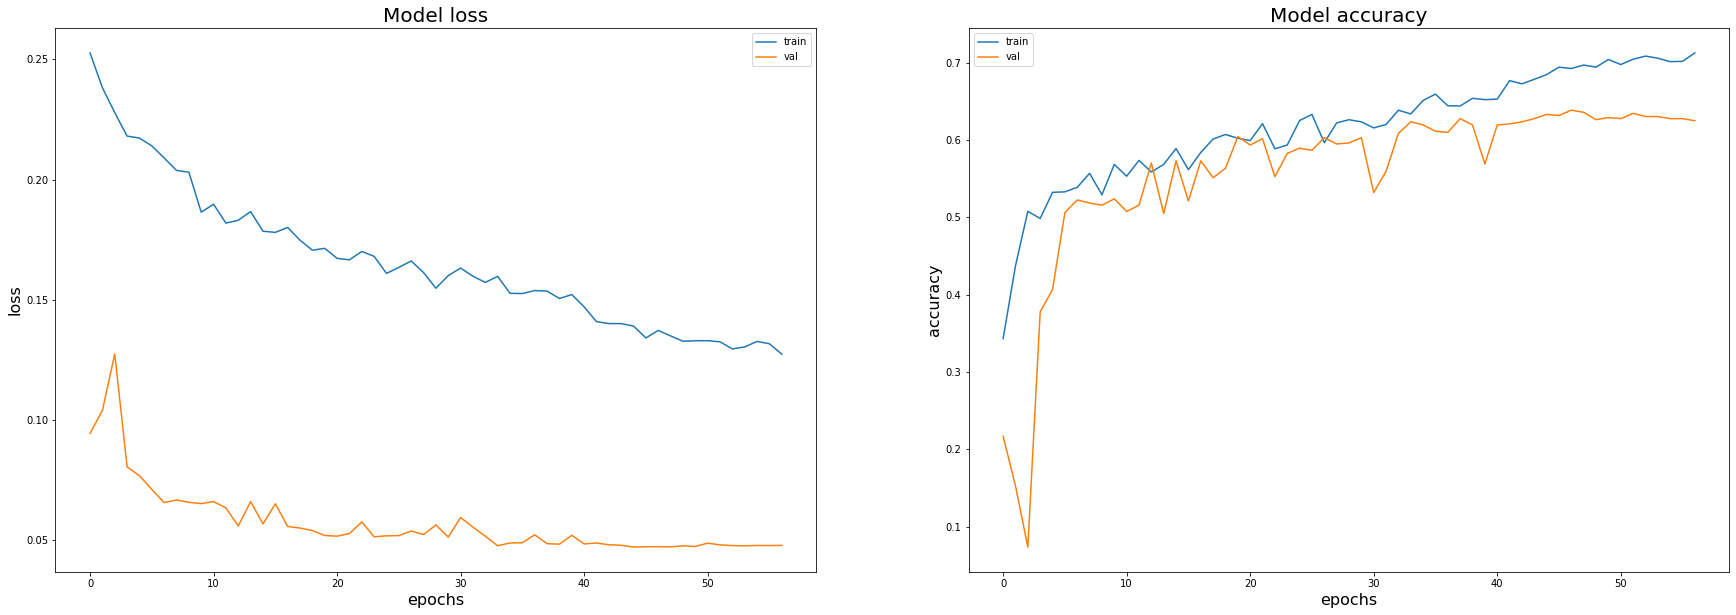

In [34]:
plot(history)

In [35]:
def plot_confusion_matrix(y, y_pred):
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Train quadratic weighted kappa:  0.6762263054514822


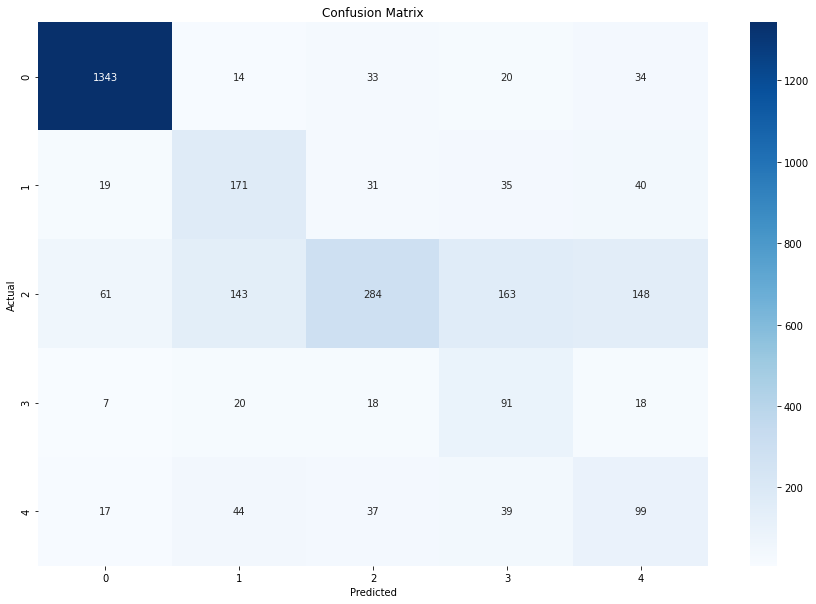

In [36]:
# train set

y = train_df["diagnosis"].values

y_pred = [np.argmax(pred) for pred in model.predict(train_ds)]

score = cohen_kappa_score(y, y_pred, weights='quadratic')
print('Train quadratic weighted kappa: ', score)

plot_confusion_matrix(y, y_pred)

## 9. Predict and evaluate results

In [37]:
loss, acc = model.evaluate(val_ds)

23/23 [==============================] - 6s 258ms/step - loss: 0.0470 - accuracy: 0.6330


Validation quadratic weighted kappa:  0.6493157157093568


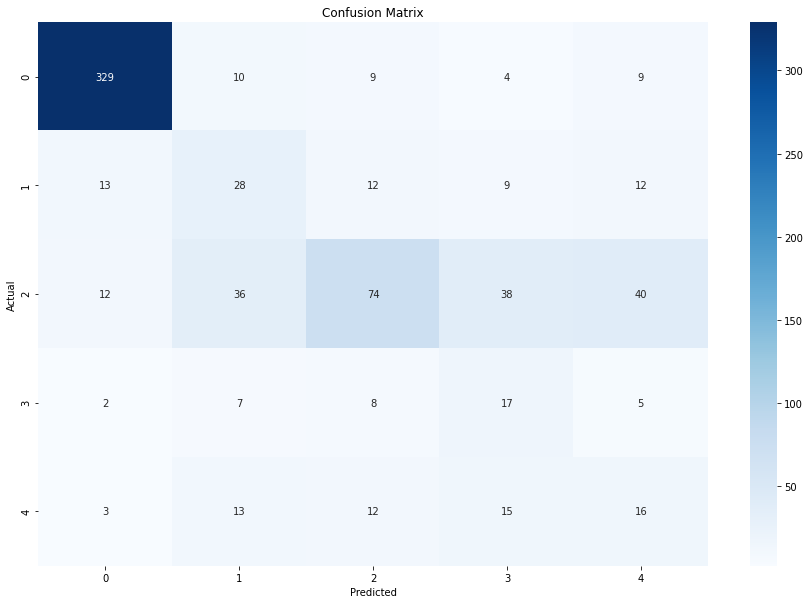

In [38]:
# val set

y = val_df["diagnosis"].values

y_pred = [np.argmax(pred) for pred in model.predict(val_ds)]

score = cohen_kappa_score(y, y_pred, weights='quadratic')
print('Validation quadratic weighted kappa: ', score)

plot_confusion_matrix(y, y_pred)

In [43]:
x = PrettyTable()

x.field_names = ["Loss", "Optimizer", "Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy", "Test QWK"]
x.add_row(["categorical_crossentropy", "adam", 1.26, 0.84, 0.97, 0.68, 0.68 ])
x.add_row(["categorical_crossentropy", "rectified adam", 2.55, 0.68, 1.08, 0.60, 0.58 ])
x.add_row(["huber", "adam", 0.13, 0.69, 0.04, 0.62, 0.61 ])
x.add_row(["huber", "rectified adam", 0.15, 0.66, 0.04, 0.65, 0.63 ])

print(x)

+--------------------------+----------------+------------+----------------+-----------+---------------+----------+
|           Loss           |   Optimizer    | Train Loss | Train Accuracy | Test Loss | Test Accuracy | Test QWK |
+--------------------------+----------------+------------+----------------+-----------+---------------+----------+
| categorical_crossentropy |      adam      |    1.26    |      0.84      |    0.97   |      0.68     |   0.68   |
| categorical_crossentropy | rectified adam |    2.55    |      0.68      |    1.08   |      0.6      |   0.58   |
|          huber           |      adam      |    0.13    |      0.69      |    0.04   |      0.62     |   0.61   |
|          huber           | rectified adam |    0.15    |      0.66      |    0.04   |      0.65     |   0.63   |
+--------------------------+----------------+------------+----------------+-----------+---------------+----------+


In [ ]:
##